In [1]:
import os
import glob
import unicodedata
import string

import random

import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

## Loadin Data

In [2]:
find_files = lambda path: glob.glob(path)

In [3]:
all_letters = string.ascii_letters + " .,;'"  #2* 26(Both lowercase and uppercase letters) + [space . , : ']
n_letters = len(all_letters)
n_letters

57

In [4]:
#function to convert unicode to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_names = {} #dictionary {'language name': names} eg. {'German': list(German names)}
all_categories = [] #list of class names (languages)

In [7]:
def read_names(filename):
    '''Function to read a file and return list of names in the file'''
    names = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(name) for name in names]

In [8]:
for filename in find_files('data/names/*.txt'):                 #loop over each file in directory
    category = os.path.splitext(os.path.basename(filename))[0]  #extract the filename i.e., the language name
    all_categories.append(category)                             #append the language name to the list
    names = read_names(filename)                                #get all the names in the file
    category_names[category] = names                            #store them in the dictionary

In [9]:
n_categories = len(all_categories)

In [10]:
print(category_names.get('German')[:5])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']


## Converting data to Tensor

In [11]:
#function to find index of a character
letterToIndex = lambda letter: all_letters.find(letter)

In [12]:
letterToIndex('a'), letterToIndex('M')

(0, 38)

In [13]:
# Turn a name into a <name_length x 1 x n_letters> tensor,
# or a tensor of one-hot vector of letters of the name
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
print(nameToTensor('Mohan').size())

torch.Size([5, 1, 57])


## Model

#### We will be training using the RNN Cell

In [15]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.w_xh = nn.Linear(input_size, hidden_size)
        self.w_hh = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x, hidden):        
        hidden = torch.tanh(self.w_xh(x) + self.w_hh(hidden)) #updating hidden state
        return hidden, hidden

In [16]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self):
        #initializing hidden state and cell state as a tensor of zeros
        hidden = torch.zeros((1,hidden_size), dtype=torch.float32)
        return hidden
        
    def forward(self, x, hidden):
        out,hidden = self.rnn(x, hidden)
        
        out = self.fc(out)
        out = self.softmax(out)
        
        return out, hidden

In [17]:
input_size = n_letters
hidden_size = 128
output_size = n_categories

In [18]:
model = Model(input_size, hidden_size, output_size)

In [19]:
#defining loss function
criterion = nn.NLLLoss()

In [20]:
learning_rate = 0.001

### Verifying if the model has no errors

In [21]:
input_x = nameToTensor('Mohan')

In [22]:
hidden = model.init_hidden()
output, next_hidden = model(input_x[0], hidden)
print(output.shape)
print(output)

torch.Size([1, 18])
tensor([[-2.8888, -2.7399, -2.9314, -3.0207, -2.8383, -3.0293, -2.7999, -2.8371,
         -2.7222, -2.9544, -2.8829, -3.0395, -2.7812, -3.0617, -2.7670, -2.9480,
         -2.9421, -2.9390]], grad_fn=<LogSoftmaxBackward0>)


In [23]:
def categoryFromOutput(output):
    '''Function to get the name of language from the output of the model'''
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    
    return all_categories[category_i], category_i

In [24]:
print(categoryFromOutput(output))

('Irish', 8)


In [25]:
def randomChoice(class_names):
    '''Function to return random name  from the class names'''
    return class_names[random.randint(0, len(class_names) - 1)]

In [26]:
randomChoice(all_categories)

'Russian'

In [27]:
def randomTrainingExample():
    '''Function to generate random training example'''
    category = randomChoice(all_categories)
    name = randomChoice(category_names[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

category = French / name = Forestier
category = Italian / name = Gentile
category = Czech / name = Hajkova
category = Czech / name = Pretsch
category = Japanese / name = Kimio
category = Vietnamese / name = Huynh
category = Arabic / name = Nazari
category = Scottish / name = Mclean
category = Italian / name = Abategiovanni
category = Polish / name = Jaskolski


In [28]:
def train_one_step(name_tensor, category_tensor):
    hidden = model.init_hidden()
    
    model.zero_grad()
    
    #Forward pass for one name
    for i in range(name_tensor.shape[0]):
        output, hidden = model(name_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    #updating parameters
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [29]:
epochs = 100000
print_every = 5000
plot_every = 1000

In [30]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [31]:
def timeSince(start):
    '''Function to track time since start'''
    now = time.time()
    s = now - start
    m = s // 60
    s -= m * 60
    return '%dm %ds' % (m, s)

In [32]:
start = time.time()

for iter in range(1, epochs + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample() #get one random training example
    output, loss = train_one_step(name_tensor, category_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        pred, pred_i = categoryFromOutput(output)
        correct = '✓' if pred == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / epochs * 100, timeSince(start), loss, name, pred, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.8957 Tong / English ✗ (Vietnamese)
10000 10% (0m 22s) 2.7011 Armani / Japanese ✗ (Italian)
15000 15% (0m 34s) 2.7630 Romao / Arabic ✗ (Portuguese)
20000 20% (0m 46s) 2.4088 Addley / Polish ✗ (English)
25000 25% (0m 58s) 3.1110 Raghailligh / Russian ✗ (Irish)
30000 30% (1m 12s) 1.7175 Ferreiro / Italian ✗ (Portuguese)
35000 35% (1m 28s) 2.8768 Power / German ✗ (Irish)
40000 40% (1m 46s) 1.6269 Kim / Korean ✗ (Vietnamese)
45000 45% (2m 2s) 0.7218 Kanada / Japanese ✓
50000 50% (2m 21s) 1.6308 Urbina / Italian ✗ (Spanish)
55000 55% (2m 37s) 2.4373 Blumenthal / Dutch ✗ (German)
60000 60% (2m 52s) 1.3377 Chong / Chinese ✗ (Korean)
65000 65% (3m 5s) 0.9106 Sneijers / Dutch ✓
70000 70% (3m 18s) 1.5148 Groel / German ✓
75000 75% (3m 32s) 3.1259 Nifterik / Polish ✗ (Dutch)
80000 80% (3m 48s) 0.6311 Polites / Greek ✓
85000 85% (4m 4s) 0.7991 Telis / Greek ✓
90000 90% (4m 22s) 1.7615 Mendes / Dutch ✗ (Portuguese)
95000 95% (4m 38s) 1.6721 Moles / Portuguese ✗ (Spanish)
100000 100

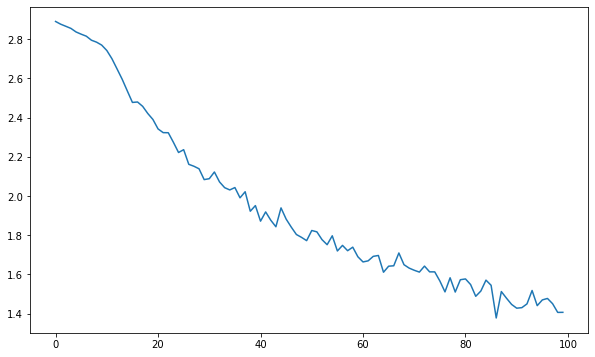

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10,6))
plt.plot(all_losses)
plt.show()

## Prediction

In [38]:
def evaluate(name_tensor):
    hidden = model.init_hidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)

    return output

In [39]:
def predict(input_name, n_predictions=3):
    print('\n> %s' % input_name)
    with torch.no_grad():
        output = evaluate(nameToTensor(input_name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.67) Russian
(-1.60) Czech
(-2.52) Scottish

> Jackson
(-1.10) Scottish
(-1.60) English
(-2.26) Russian

> Satoshi
(-0.79) Japanese
(-1.66) Arabic
(-1.88) Italian


Reference: [Pytorch documentation](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial)